# Using unique values to compress data


## Imports


In [43]:
import numpy as np
from signal_processing_utilities import process_signal
from glob import glob
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import time 
plt.style.use("ggplot")

## Creating the data


In [45]:
data_dir = "../../data/"
data_dir_l = glob(data_dir + "*.wav")
current_file = data_dir_l[0]
current_file

'../../data/102b47d9-371e-412a-8995-0dc6115ab2bb.wav'

In [164]:
def encode_unique_amplitudes_indices(current_file:str):
    sample_rate, data = wavfile.read(current_file)
    data_df = pd.DataFrame(data)
    data_df.columns = ["Amplitude"]

    unique_amplitudes = pd.DataFrame(np.unique(data_df))
    unique_amplitudes_index_l = []

    for index in range(0, len(data_df)):
        unique_amplitudes_index_l.append(unique_amplitudes.index[unique_amplitudes[0]==data_df["Amplitude"][index]][0])

    data_df["unique_amplitudes_index_l"] = np.array(unique_amplitudes_index_l)
    indices_uint8 = np.array(data_df["unique_amplitudes_index_l"].values, dtype=np.uint8)
    unique_amplitudes_l = unique_amplitudes[0].values
    return unique_amplitudes_l, indices_uint8

In [165]:
unique_amplitudes_l, indices_uint8 = encode_unique_amplitudes_indices(current_file)

In [75]:
print(f"{unique_amplitudes_l}")
indices_uint8

[-4132 -4068 -3940 -3876 -3812 -3748 -3684 -3619 -3555 -3491 -3427 -3363
 -3299 -3235 -3171 -3107 -3043 -2979 -2915 -2851 -2787 -2723 -2659 -2594
 -2530 -2466 -2402 -2338 -2274 -2210 -2146 -2082 -2018 -1954 -1890 -1826
 -1762 -1698 -1634 -1570 -1505 -1441 -1377 -1313 -1249 -1185 -1121 -1057
  -993  -929  -865  -801  -737  -673  -609  -545  -480  -416  -352  -288
  -224  -160   -96    31    95   159   223   287   351   415   479   544
   608   672   736   800   864   928   992  1056  1120  1184  1248  1312
  1376  1440  1504  1569  1633  1697  1761  1825  1889  1953  2017  2081
  2145  2209  2273  2337  2401  2465  2529  2593  2658  2722  2786  2850
  2914  2978  3042  3106  3170  3234  3298  3362  3426  3490  3554  3618
  3683  3747  3811  3875  3939  4003  4067  4131  4195  4259  4323  4387
  4451  4515  4579  4643  4708  4772  4836  4900  4964  5028  5092  5156
  5220  5284  5348  5412  5476  5540  5604  5668  5797  5861  5925  6053
  6181  6437]


array([58, 57, 59, ..., 67, 66, 59], dtype=uint8)

In [49]:
compressed_file_path = 'data/sample_data.brainwire'
# Format: 
# ∙ 1 byte is length of the unique amplitudes list
# ∙ 2 bytes per amplitude in the unique amplitudes list for the length of the list
# ∙ 1 byte for the rest of the length of the file

with open("data/sample_data.brainwire", 'wb+') as fp:
    fp.write(np.array(len(unique_amplitudes_l), dtype=np.uint8))
    for index, value in enumerate(unique_amplitudes_l):
        fp.write(value)
    for index, value in enumerate(indices_uint8):
        fp.write(value)
    fp.close()


In [50]:
process_signal.print_size_of_file_compression(file_path=current_file, compressed_file_path=compressed_file_path)

Original File Size: 197442
Compressed File Size: 99016
Percent of Compression: 49.85%
Percent of Compressed File Size Relative to Required File Size: 10032.016%


## Decoding the data


In [163]:
start_time = time.time_ns()
with open(compressed_file_path, "rb+") as fp:
    file = fp.read()
    fp.close()
cutoff_index = ((2*file[0]) + 1)
unique_amplitudes_reconstructed_values = np.frombuffer(file[1:cutoff_index], dtype=np.int16, count=file[0])
indices_reconstructed = np.frombuffer(file[cutoff_index:], dtype=np.uint8)
stop_time = time.time_ns()
process_signal.print_time_each_function_takes_to_complete_processing(start_time, stop_time)




Time Δ Nanoseconds: 2611000
Time Δ Microseconds: 2611.0
Time Δ Milliseconds: 2.611
Time Δ Seconds: 0.002611




In [152]:
unique_amplitudes_reconstructed_values
indices_reconstructed

array([58, 57, 59, ..., 67, 66, 59], dtype=uint8)

In [161]:
original_data = unique_amplitudes_reconstructed_values[indices_reconstructed]

In [162]:
original_data

array([-352, -416, -288, ...,  287,  223, -288], dtype=int16)

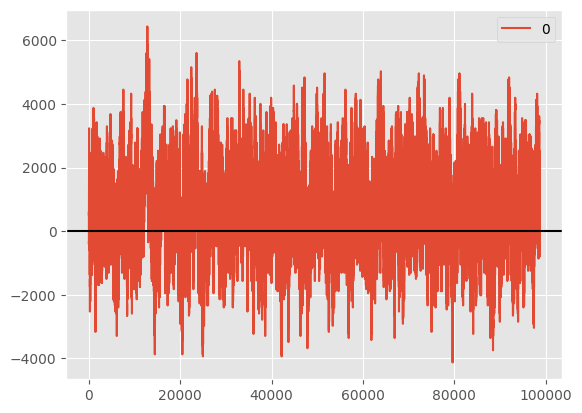

In [160]:
pd.DataFrame(unique_amplitudes_reconstructed_values[indices_reconstructed]).plot()
plt.axhline(y=0, color='black')